# SC23x
 
## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 데이터를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 이 [PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 목표: 오늘 여러분은 Chicago시의 공중보건부에서 진행한 레스토랑들의 위생 검사 "불합격" 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
import sys
import xgboost
import warnings


if "google.colab" in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

warnings.filterwarnings("ignore")
# xgboost.config.set_config(verbosity=0)

In [2]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv"
test_url = "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv"

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape == (20000, 17)

In [3]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2050629,MY SWEET STATION INC,MY SWEET STATION,2327223.0,Restaurant,Risk 1 (High),2511 N LINCOLN AVE,CHICAGO,IL,60614.0,2017-05-18,Canvass,NaN,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
1,2078428,OUTTAKES,RED MANGO,2125004.0,Restaurant,Risk 2 (Medium),10 S DEARBORN ST FL,CHICAGO,IL,60603.0,2017-08-14,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.881807,-87.629543,"(-87.62954311539407, 41.88180696006542)",0
2,1591748,JAFFA BAGELS,JAFFA BAGELS,2278918.0,Restaurant,Risk 1 (High),225 N MICHIGAN AVE,CHICAGO,IL,60601.0,2015-12-15,Complaint,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.886377,-87.624382,"(-87.62438167043969, 41.88637740620821)",0
3,1230035,FRANKS 'N' DAWGS,FRANKS 'N' DAWGS,2094329.0,Restaurant,Risk 1 (High),1863 N CLYBOURN AVE,CHICAGO,IL,60614.0,2012-07-10,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.914990,-87.654994,"(-87.65499361162448, 41.91498953039437)",0
4,1228186,SOUTH COAST,SOUTH COAST SUSHI,1817424.0,Restaurant,Risk 1 (High),1700 S MICHIGAN AVE,CHICAGO,IL,60616.0,2013-09-20,Canvass,NaN,41.858996,-87.624106,"(-87.62410566978502, 41.85899630014676)",0


# Part 1 - Data Preprocessing

In [4]:
test["Inspection Fail"]

0        0
1        0
2        0
3        0
4        0
        ..
19995    0
19996    0
19997    0
19998    0
19999    0
Name: Inspection Fail, Length: 20000, dtype: int64

## 컬럼 설명

- **DBA**: 설립 시 서류에 등록한 이름

- **AKA**: 대중들에게 알려져 있는 상표 이름

- **License number**: 사업자 고유번호 (사업자등록번호)

- **Type of facility**: 매장 업종 

    bakery, banquet hall, candy store, caterer, coffee shop, day care center (for ages less than 2), day care center (for ages 2 – 6), day care center (combo, for ages less than 2 and 2-6 combined), gas station, Golden Diner, grocery store, hospital, long term care center(nursing home), liquor store, mobile food dispenser, restaurant, paleteria, school, shelter, tavern, social club, wholesaler, or Wrigley Field Rooftop.
    
    
- **Risk**: 위험 시설 분류 카테고리 : 국민 건강에 악영향을 미칠 위험이 얼마나 높은 시설인가? (1이 가장 높고, 3이 가장 낮은 카테고리임. 위험 1 시설이 검사 빈도가 높은 편이고, 위험 3 시설이 검사 빈도가 낮은 편)

- **Address, City, State, Zip**: 해당 시설이 위치한 주소 (Full Address)

- **Inspection date**: 검사 날짜. (어떤 사업장은 동일한 사업장명에 각기 다른 검사 날짜를 가지고 있을 수도 있음)

- **Inspection type**: 검사 유형. (각 이유에 대해 Re-inspection이 붙으면 재검사한 것)
    - Canvass : 시설의 위험도와 관련된 가장 이란적인 유형의 검사. 
    - Consultation : 개업 전 소유자의 요청으로 검사를 수행.
    - Complaint : 민원 사항 발생 시 검사를 수행할 때.
    - License : 사업장의 영업허가서 발금 요건으로 검사를 할 때.
    - Suspect Food Poisoning : 사업장에서 식사 (민원 처리 된 특정 유형의 검사)로 인해 병에 걸렸다고 주장하는 1인 이상에게 검사를 할 때.
    - Task-force Inspection : 술집 또는 주점의 검사가 수행된 경우
    
- **Inspection Fail**: 검사 결과(불합격 여부)
    - 실패를 받는다고 해서 반드시 사업장 면허가 정지되는 것은 아님.
    
- **Violations**: 위반사항. 위반사항을 지칭하는 고유번호와 위반한 사항 및 시정 요건에 대한 설명이 주어짐.

## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요.
- 아래 기본적인 EDA 과정을 위해 필요한 몇몇 함수들을 완성하세요.
- 함수의 기능 및 입출력 형태는 함수 내의 주석을 따르세요.
- **아래 EDA 과정만으로는 데이터에 대한 통찰을 얻기에 부족합니다. 추가로 본인만의 EDA 과정을 꼭 수행해 보세요.**

In [5]:
def analysis_on_features(df):
    """
    - eda_results라고 하는 새로운 데이터프레임에 아래의 정보들을 담아 반환하세요.
        - null_count: 입력 Pandas DataFrame의 column별 결측치의 수
        - num_unique_values: 입력 Pandas DataFrame의 unique한 값의 수
        - eda_results는 df의 column명을 index로 사용하는 데이터프레임입니다.

    - 데이터프레임에 중복되는 row가 있지는 않나요?
        - duplicated_rows에 중복되는 row 수를 담아 반환하세요.

    """
    eda_results = pd.DataFrame()
    eda_results["null_count"] = None
    eda_results["num_unique_values"] = None
    duplicated_rows = -1

    ### BEGIN SOLUTION
    eda_results["null_count"] = df.isnull().sum()
    eda_results["num_unique_values"] = df.nunique()
    duplicated_rows = df.duplicated().sum()
    ### END SOLUTION

    return eda_results, duplicated_rows

In [6]:
train_results, train_duplicated_rows = analysis_on_features(train)
test_results, test_duplicated_rows = analysis_on_features(test)

In [7]:
print(f"Train df: duplicated? = {train_duplicated_rows}\n", train_results, "\n\n")
print(f"Test df: duplicated? = {test_duplicated_rows}\n", test_results)
### BEGIN HIDDEN TESTS
assert all(train_results["null_count"] == train.isnull().sum()), AssertionError("pd.DataFrame의 isnull 메서드를 사용해 보세요.")
assert all(train_results["num_unique_values"] == train.nunique()), AssertionError("pd.DataFrame의 nunique 메서드를 사용해 보세요.")
assert train_duplicated_rows == train.duplicated().sum(), AssertionError("pd.DataFrame의 duplicated 메서드를 사용해 보세요.")

assert all(test_results["null_count"] == test.isnull().sum()), AssertionError("pd.DataFrame의 isnull 메서드를 사용해 보세요.")
assert all(test_results["num_unique_values"] == test.nunique()), AssertionError("pd.DataFrame의 nunique 메서드를 사용해 보세요.")
assert test_duplicated_rows == test.duplicated().sum(), AssertionError("pd.DataFrame의 duplicated 메서드를 사용해 보세요.")
### END HIDDEN TESTS

Train df: duplicated? = 0
                  null_count  num_unique_values
Inspection ID             0              60000
DBA Name                  0              20175
AKA Name                717              19209
License #                 4              25123
Facility Type          1427                366
Risk                     24                  4
Address                   0              15244
City                     45                 39
State                    15                  3
Zip                      13                 86
Inspection Date           0               2667
Inspection Type           0                 55
Violations            15870              44035
Latitude                178              14533
Longitude               178              14533
Location                178              14533
Inspection Fail           0                  2 


Test df: duplicated? = 0
                  null_count  num_unique_values
Inspection ID             0              20000
DBA 

In [8]:
import matplotlib.pyplot as plt


def analysis_on_target(df):
    """
    n_zero_label, n_one_label에
    각각 label이 0인 데이터의 수, label이 1인 데이터의 수를 담아 반환하세요.
    """
    n_zero_label, n_one_label = -1, -1

    ### BEGIN SOLUTION
    n_zero_label, n_one_label = df["Inspection Fail"].value_counts().loc[[0, 1]]
    ### END SOLUTION

    plt.pie(
        (n_zero_label, n_one_label),
        labels=(0, 1),
        autopct="%.2f%%",
        shadow=True,
        startangle=90,
    )
    plt.title("Target: Inspection Fail", size=15)
    plt.show()

    return n_zero_label, n_one_label

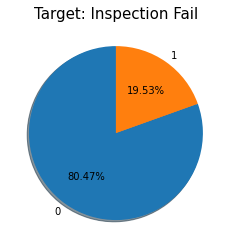

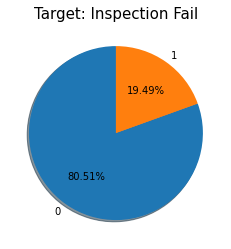

In [9]:
train_label_count = analysis_on_target(train)
test_label_count = analysis_on_target(test)
### BEGIN HIDDEN TESTS
assert train_label_count == tuple(train["Inspection Fail"].value_counts().loc[[0, 1]]), 'train label 분포를 잘못 구했습니다.'
assert test_label_count == tuple(test["Inspection Fail"].value_counts().loc[[0, 1]]), 'test label 분포를 잘못 구했습니다.'
### END HIDDEN TESTS

In [10]:
print(
    """
이 셀에서 추가로 데이터를 자유롭게 분석해 보세요.
- 이 셀에서의 작업은 채점하지 않습니다.
- 채점 시 이 셀에서 작업한 내용은 전부 무시됩니다.
- 제출 전에 이 셀의 내용을 모두 주석 처리한 후 모든 코드가 순차적으로 오류 없이 실행되는지 꼭 확인하세요.
"""
)


이 셀에서 추가로 데이터를 자유롭게 분석해 보세요.
- 이 셀에서의 작업은 채점하지 않습니다.
- 채점 시 이 셀에서 작업한 내용은 전부 무시됩니다.
- 제출 전에 이 셀의 내용을 모두 주석 처리한 후 모든 코드가 순차적으로 오류 없이 실행되는지 꼭 확인하세요.



## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 수행하는 함수 `eda_process`를 작성하세요.

- 결측치를 적절히 처리하세요.
    - **Row를 drop하지 말고, 적절한 값으로 채워넣어 보세요.**
    - 전처리가 완료된 train, test 데이터의 크기는 각각 **59947, 19994**입니다.
- 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다.
- 시간 배분을 고려햐여 적절한 수준으로 수행하세요!

In [11]:
# import any libraries needed
### BEGIN SOLUTION
from collections import Counter

### END SOLUTION


def eda_process(df):
    # State 컬럼 처리 : 결측치 및 IL이 아닌 row 삭제
    df.dropna(subset=["State"], how="any", axis=0, inplace=True)
    df = df.query("State == 'IL'")

    # Risk : 결측치 및 All 삭제 > 1, 2, 3으로 바꾸어 줌
    df.dropna(subset=["Risk"], how="any", axis=0, inplace=True)
    df = df.query("Risk != 'All'")
    df.replace("Risk 1 (High)", 1, inplace=True)
    df.replace("Risk 2 (Medium)", 2, inplace=True)
    df.replace("Risk 3 (Low)", 3, inplace=True)

    ### BEGIN SOLUTION

    def get_topk_set(series, topk):
        return set(
            map(lambda x: x[0], Counter(series[series.notna()]).most_common(topk))
        )

    # City 컬럼 처리 : Chicago가 맞는 곳과 아닌 곳으로 구분
    Chicago_list = {
        "CHICAGO",
        "312CHICAGO",
        "CHCICAGO",
        "CHICAGO.",
        "CHICAGOI",
        "CHICAGOCHICAGO",
        "CCHICAGO",
    }
    df["City"] = df["City"].str.upper()
    df["City_Chicago"] = df["City"].apply(lambda x: x in Chicago_list)

    # Inspection date를 string에서 datetime으로 바꾼 후 연도, 월 추출
    df["Inspection Date"] = df["Inspection Date"].apply(pd.to_datetime)
    df["year"] = df["Inspection Date"].dt.year
    df["month"] = df["Inspection Date"].dt.month

    # Cardinality 줄이기 1 : Facility type upper case > value_counts TOP10 이외는 etc로 처리
    df["Facility Type"] = df["Facility Type"].str.upper()
    facility_top10 = get_topk_set(df["Facility Type"], 10)
    df["Facility Type"] = df["Facility Type"].apply(
        lambda x: x if x in facility_top10 else "ETC"
    )

    # Cardinality 줄이기 2 : Inspection Type upper case > value_counts TOP10 이외는 etc로 처리
    df["Inspection Type"] = df["Inspection Type"].str.upper()
    inspection_top10 = get_topk_set(df["Inspection Type"], 10)
    df["Inspection Type"] = df["Inspection Type"].apply(
        lambda x: x if x in inspection_top10 else "ETC"
    )

    # Cardinality 줄이기 3 : Violations을 위반사항 "개수"로 변환
    df["Violations"] = df["Violations"].apply(
        lambda x: 0 if not isinstance(x, str) else len(x.split("| "))
    )

    # Cardinality 줄이기 4 : License # > 결측치는 0, 고유번호가 있으면 1
    df["License #"].fillna(0, inplace=True)
    df["License"] = 1 - (df["License #"] == 0)

    # Cardinality 줄이기  5 : Name 정제
    df["Name"] = df["DBA Name"].str.upper()
    replace_mappings = {
        "MCDONALDS": "MCDONALD|MC DONALD",
        "SUBWAY": "SUBWAY",
        "POTBELLY": "POTBELLY",
        "JIMMYJOHNS": "JIMMY JOHN|JIMMYJOHN",
        "DUNKIN AND BASKIN": "DUNKIN DONUTS BASKIN ROBBINS|DUNKIN DONUTS/BASKIN ROBBINS|DUNKIN DONUTS / BASKIN ROBBINS",
        "KFC": "KENTUCKY FRIED CHICKEN|KFC",
        "WENDY": "WENDY",
        "POPEYE": "POPEYE",
        "DOMINO": "DOMINO",
        "REGGIO": "REGGIO",
        "ELEVEN": "7-ELEVEN",
        "STARBUCKS": "STARBUCKS",
        "PAPA JOHN": "PAPA JOHN",
        "TACO BELL": "TACO BELL",
        "WINGSTOP": "WINGSTOP",
        "SEE THRU CHINESE KITCHEN": "SEE THRU CHINESE KITCHEN",
        "HAROLD": "HAROLD'S CHICKEN",
        "PIZZA HUT": "PIZZA HUT",
        "CHARTWELLS": "CHARTWELLS",
    }

    for k in replace_mappings:
        detected_names = df["Name"][df["Name"].str.contains(replace_mappings[k])]
        df.replace(detected_names, k, inplace=True)

    # 필요한 features 선택
    features = [
        "Name",
        "year",
        "month",
        "License",
        "Facility Type",
        "City_Chicago",
        "Latitude",
        "Longitude",
        "Risk",
        "Inspection Type",
        "Violations",
        "Inspection Fail",
    ]
    df = df[features]
    ### END SOLUTION

    return df

In [12]:
train_processed = eda_process(train.copy())
test_processed = eda_process(test.copy())
print(train_processed.shape, test_processed.shape)
assert len(train_processed) == 59947, "train data 전처리가 잘못되었습니다. 조건을 다시 확인하세요."
assert len(test_processed) == 19994, "test data 전처리가 잘못되었습니다. 조건을 다시 확인하세요."

(59947, 12) (19994, 12)


### 전처리 후 target 분포의 변화를 다시 확인해 보세요.

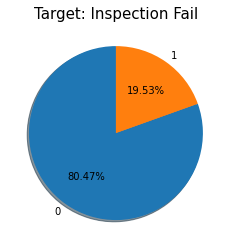

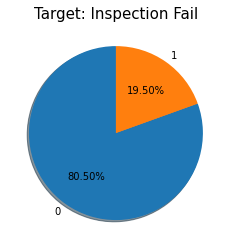

(16096, 3898)

In [13]:
analysis_on_target(train_processed)
analysis_on_target(test_processed)

# Part 2 - Modeling

## 2.1 데이터를 feature (X), label(y)로 분할하는 `divide_data` 함수를 작성하세요.
- Target Column은 `Inspection Fail`입니다.

In [14]:
def divide_data(df):
    X = None
    y = None

    ### BEGIN SOLUTION
    target = "Inspection Fail"
    y = df[target]
    X = df.drop(target, axis=1)
    ### END SOLUTION

    return X, y

In [15]:
X_train, y_train = divide_data(train_processed)
X_test, y_test = divide_data(test_processed)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
### BEGIN HIDDEN TESTS
if isinstance(y_train, pd.Series):
    assert y_train.name == "Inspection Fail", "Target column을 다시 확인하세요."
else:
    assert isinstance(y_train, pd.DataFrame) & (
        set(y_train.columns) == {"Inspection Fail"}
    ), "Target column을 다시 확인하세요."
assert "Inspection Fail" not in set(X_train.columns), "Data에 Target column이 포함되어 있습니다."
### END HIDDEN TESTS

(59947, 11) (59947,) (19994, 11) (19994,)


## 2.2 모델을 생성하고 학습하는 `fit` 함수와 1일 확률을 반환하는 `predict` 함수를 작성하세요. 
- Scikit-learn의 `pipeline`을 활용하여 학습 파이프라인을 생성하세요.
- Boosting 모델을 사용하고자 할 경우 XGBoost를 사용하세요.
- `RandomizedSearchCV`를 사용해 CV를 진행하세요.
    - 적어도 두 개 이상의 하이퍼파라미터에 대해 탐색을 진행하세요.
    - **AUC score을 최대화하는 하이퍼파라미터 조합을 선택하세요.**
- cv는 5 이하, n_iter은 10회 이하로 하세요.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# import any libraries needed
### BEGIN SOLUTION
import sklearn
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, OneHotEncoder

### END SOLUTION


def fit(X_train, y_train):
    pipeline = None  # pipeline = make_pipeline(...)
    clf = None  # clf = RandomizedSearchCV(pipeline, ...)

    ### BEGIN SOLUTION
    pipeline = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy="median"),
        XGBClassifier(
            n_estimators=1000,
            verbosity=0,
            max_depth=7,
            learning_rate=0.2,
            scale_pos_weight=sum(1 - y_train) / sum(y_train),
            n_jobs=-1,
            random_state=2,
        ),
    )

    dists = {
        "xgbclassifier__n_estimators": [100, 200, 500, 1000],
        "xgbclassifier__max_depth": [3, 5, 7, 9],
        "xgbclassifier__learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
        "xgbclassifier__max_delta_step": [1, 2, 5],
    }

    clf = RandomizedSearchCV(
        pipeline,
        param_distributions=dists,
        n_iter=3,
        scoring="roc_auc",
        verbose=1,
        n_jobs=-1,
    )
    ### END SOLUTION

    clf.fit(X_train, y_train)
    print("Optimal Hyperparameter:", clf.best_params_)
    print("AUC:", clf.best_score_)

    return clf


def predict(X, y, best_estimator):
    y_pred_proba = None

    ### BEGIN SOLUTION
    y_pred_proba = best_estimator.predict_proba(X)[:, 1]
    ### END SOLUTION

    report = classification_report(y, y_pred_proba > 0.5)
    return y_pred_proba, report

In [19]:
clf = fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Optimal Hyperparameter: {'xgbclassifier__n_estimators': 200, 'xgbclassifier__max_depth': 7, 'xgbclassifier__max_delta_step': 5, 'xgbclassifier__learning_rate': 0.1}
AUC: 0.8317253488840659


### 아래 셀을 실행시켜 모델의 Test score을 확인해 보세요.
- auc_score > 0.65을 만족하면 기본 성능점수를 얻습니다.
- (도전과제) auc_score > 0.8을 만족하면 성능점수 만점을 얻습니다.
    - 도전과제까지 수행해야 스챌 3점을 얻습니다. 
    - 1.3으로 돌아가 다양한 특성 조합을 시도해 보세요. 
    - 2.2로 돌아가 SearchCV에서 다양한 하이퍼파라미터 옵션 조합을 선택해 보세요.
        - 본인이 선택한 모델에서, 각 하이퍼파라미터가 어떤 의미를 가지나요?
        - SearchCV가 더 다양한 하이퍼파라미터 조합을 시도하도록 하기 위해 SearchCV의 어떤 옵션을 조정해야 할까요?

              precision    recall  f1-score   support

           0       0.91      0.81      0.86     16096
           1       0.46      0.69      0.55      3898

    accuracy                           0.78     19994
   macro avg       0.69      0.75      0.70     19994
weighted avg       0.83      0.78      0.80     19994



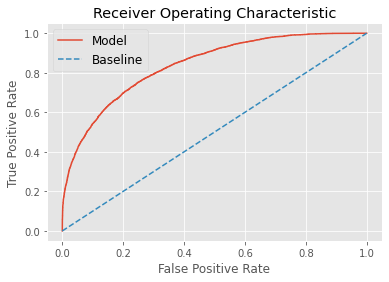

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score


def plot_roc(y, y_pred_proba):
    auc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("Receiver Operating Characteristic")
    plt.legend(prop={"size": 12})
    plt.show()
    return auc_score


y_test_pred_proba, report = predict(X_test, y_test, clf.best_estimator_)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)

In [21]:
print("Test AUC:", auc_score)
### BEGIN HIDDEN TESTS
assert len(clf.param_distributions.values()) >= 2, "2개 이상의 하이퍼파라미터에 대해 탐색을 시도하세요."
assert clf.scoring.lower() == "roc_auc", "AUC score을 최적화하도록 CV를 구성하세요."
assert auc_score > 0.65, "AUC <= 0.65입니다."
### END HIDDEN TESTS

Test AUC: 0.8379578305564255


In [22]:
print("Test AUC > 0.8?:", auc_score > 0.8)
### BEGIN HIDDEN TESTS
assert auc_score > 0.8, "AUC <= 0.8입니다."
### END HIDDEN TESTS

Test AUC > 0.8?: True


# Part 3 - Visualization
- `eli5`의 `PermutationImportance`, `pdpbox` 등의 라이브러리에서는 이미 전처리가 완료되어 수치형 자료로 변환된 독립변수들을 입력으로 받습니다.
- 따라서, 2.2에서 생성한 pipeline을 **전처리를 위한 부분**과 **예측 모델**로 나눠 주어야 합니다.
    - 전처리를 위한 부분을 거친 후에는 모든 특성들이 수치형이어야 합니다. 
- 아래 셀에서 해당 과정을 수행해 주세요.
    1. `pipeline`을 `preprocess_pipeline`과 `model`로 나눠 주세요.
    2. `preprocess_pipeline`으로 `X_test`를 transform하여 `X_test_preprocessed`를 생성하세요.

In [23]:
pipeline = clf.best_estimator_

# TODO: pipeline을 preprocess_pipeline과 model로 나눠 주세요.
preprocess_pipeline = None
model = None
### BEGIN SOLUTIONS
preprocess_pipeline = pipeline[:-1]
model = pipeline[-1]
### END SOLUTIONS

# TODO: X_test를 preprocess_pipeline에 통과시켜 X_test_preprocessed를 만드세요.
X_test_preprocessed = None
### BEGIN SOLUTIONS
X_test_preprocessed = preprocess_pipeline.transform(X_test)
### END SOLUTIONS

## 3.1 Permutation Importance를 계산하는 `get_permutation_importance` 함수를 작성하세요.
- AUC score을 기준으로 Permutation Importance를 계산하는 permuter을 생성, fit하여 반환하세요.
- `n_iter=5`로 하세요.

In [24]:
import eli5
from eli5.sklearn import PermutationImportance


def get_permutation_importance(X, y, model):
    permuter = None
    # permuter = PermutationImportance(..., n_iter=5, random_state=42)

    ### BEGIN SOLUTION
    permuter = PermutationImportance(
        model, scoring="roc_auc", n_iter=5, random_state=42
    )

    ### END SOLUTION
    permuter.fit(X, y)

    return permuter

In [27]:
permuter = get_permutation_importance(X_test_preprocessed, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test.columns.tolist())
print("Top3 Important Features:")
p_i = sorted(
    list(zip(X_test.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i[:3])
### BEGIN HIDDEN TESTS
assert permuter.n_iter == 5, 'n_iter != 5입니다. 조건을 다시 확인하세요.'
assert permuter.scoring == "roc_auc", 'AUC score을 기준으로 Permutation Importance를 계산하세요.'
### END HIDDEN TESTS

Top3 Important Features:
[('Violations', 0.2501557611743597), ('Inspection Type', 0.0904135060085868), ('year', 0.04215549602589701)]


### 위 결과를 기반으로, 아래의 질문에 답해 보세요. 
- 확인할 수 없으면 `"모름"`으로 답하세요.
- 답이 하나이면 `String`, 여러 개이면 `List`로 답하세요.


- **문제 1.** 평균적으로 모델의 성능에 가장 많은 영향을 주는 특성은 무엇인가요?
- **문제 2.** 모델의 예측값과 양의 상관관계를 갖는 특성은 무엇인가요?
- **문제 3.** 모델의 예측값과 음의 상관관계를 갖는 특성은 무엇인가요?


In [28]:
answer_1 = None
answer_2 = None
answer_3 = None

### BEGIN SOLUTION
absmax = sorted(p_i, key=lambda x: abs(x[1]), reverse=True)[0]
valmax = sorted(p_i, key=lambda x: x[1], reverse=True)[0]
if absmax == valmax:
    answer_1 = absmax[0]
else:
    answer_1 = "모름"
answer_2 = answer_3 = "모름"
### END SOLUTION

In [29]:
print("A1:", answer_1)
print("A2:", answer_2)
print("A3:", answer_3)

### BEGIN HIDDEN TESTS
_absmax = sorted(p_i, key=lambda x: abs(x[1]), reverse=True)[0]
_valmax = sorted(p_i, key=lambda x: x[1], reverse=True)[0]
if _absmax == _valmax:
    assert answer_1.lower() == _absmax[0].lower(), 'A1이 틀렸습니다.'
else:
    assert answer_1 == "모름", 'A1이 틀렸습니다.'
assert answer_2 == "모름", 'A2가 틀렸습니다.'
assert answer_3 == "모름", 'A3이 틀렸습니다.'
### END HIDDEN TESTS

A1: Violations
A2: 모름
A3: 모름


## 3.2 1변수 PDP Plot을 생성하는 `get_pdp_isolated` 함수를 작성하세요.
- `feature`의 특성을 변수로 하는 1변수 PDP Plot을 생성합니다.

In [30]:
from pdpbox.pdp import pdp_isolate, pdp_plot


def get_pdp_isolated(dataset, model, feature):
    pdp_isolated = None

    ### BEGIN SOLUTION
    pdp_isolated = pdp_isolate(
        model=model,
        dataset=dataset,
        model_features=dataset.columns,
        feature=feature,
    )
    ### END SOLUTION

    return pdp_isolated

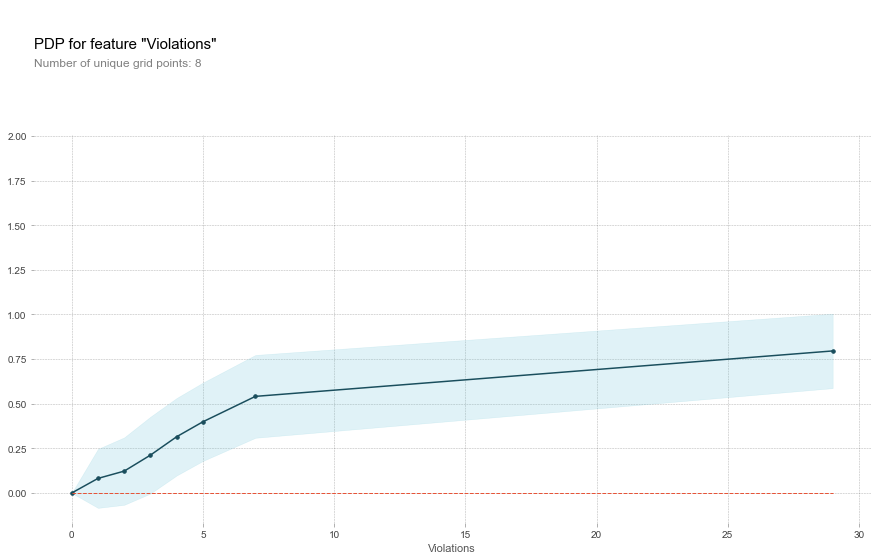

In [31]:
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)
feature = sorted(p_i, key=lambda x: x[1], reverse=True)[0][0]
pdp_isolated = get_pdp_isolated(X_test_preprocessed_df, model, feature)
pdp_plot(pdp_isolated, feature_name=feature)
### BEGIN HIDDEN TESTS
from pdpbox.pdp import PDPIsolate

assert isinstance(pdp_isolated, PDPIsolate)
### END HIDDEN TESTS

### 위 결과를 기반으로, 아래의 질문에 답해 보세요. 
- `True`/`False`로 답하고 그 이유를 한 줄로 작성하세요.


- **문제 1.** 위 Plot은 해당 특성에 따른 실제 label값의 양상을 나타낸 것이다.
- **문제 2.** 위 Plot은 해당 특성에 따른 모델의 label 예측값의 양상을 나타낸 것이다.
- **문제 3.** 선형회귀 모델(Linear Regression)에서 isolated PDP는 데이터의 분포와는 무관하게 항상 직선이다.
- **문제 4.** 선형회귀 모델(Linear Regression)의 isolated PDP에서 여러 개의 서로 다른 ICE 곡선이 나올 수 있다.


In [32]:
answer_1 = False  # True / False
reason_1 = ""
answer_2 = False  # True / False
reason_2 = ""
answer_3 = False  # True / False
reason_3 = ""
answer_4 = False  # True / False
reason_4 = ""

### BEGIN SOLUTION
answer_1 = False
answer_2 = True
answer_3 = True
answer_4 = False
### END SOLUTION

In [33]:
print("A1:", answer_1, "Why?:", reason_1)
print("A2:", answer_2, "Why?:", reason_2)
print("A3:", answer_3, "Why?:", reason_3)
print("A4:", answer_4, "Why?:", reason_4)

### BEGIN HIDDEN TESTS
assert answer_1 == False, 'A1이 틀렸습니다.'
assert answer_2 == True, 'A2가 틀렸습니다.'
assert answer_3 == True, 'A3이 틀렸습니다.'
assert answer_4 == False, 'A4가 틀렸습니다.'
### END HIDDEN TESTS

A1: False Why?: 
A2: True Why?: 
A3: True Why?: 
A4: False Why?: 


## 3.3 2변수 PDP Plot을 생성하는 `get_pdp_interaction` 함수를 작성하세요.

In [34]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot


def get_pdp_interaction(dataset, model, features):
    pdp_interaction = None

    ### BEGIN SOLUTION
    pdp_interaction = pdp_interact(
        model=model,
        dataset=dataset,
        model_features=dataset.columns,
        features=features,
    )
    ### END SOLUTION

    return pdp_interaction

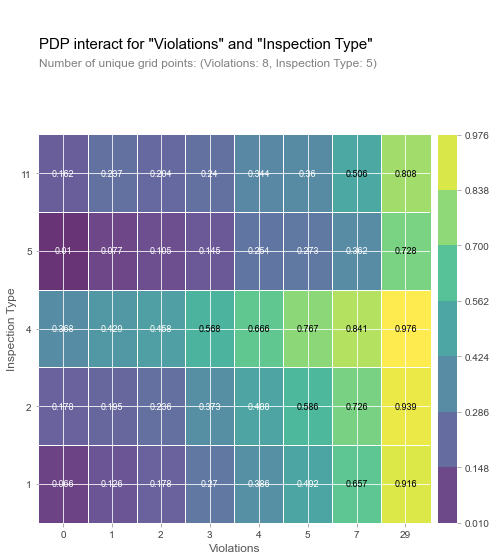

/Users/codestates/Library/Python/3.8/lib/python/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/codestates/Library/Python/3.8/lib/python/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/codestates/Library/Python/3.8/lib/python/site-p

/Users/codestates/Library/Python/3.8/lib/python/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/codestates/Library/Python/3.8/lib/python/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/codestates/Library/Python/3.8/lib/python/site-p

In [35]:
features = list(map(lambda x: x[0], sorted(p_i, key=lambda x: x[1], reverse=True)))[:2]
pdp_interaction = get_pdp_interaction(X_test_preprocessed_df, model, features)
pdp_interact_plot(pdp_interaction, feature_names=features, plot_type="grid")
### BEGIN HIDDEN TESTS
from pdpbox.pdp import PDPInteract

assert isinstance(pdp_interaction, PDPInteract)
### END HIDDEN TESTS